# MCH Sampa digitization

In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

In [6]:
def baseFunc(x,n,a):
    return math.exp(-a*x)*x**n

def gammaIntegral(n,a):
    return math.gamma(n+1)/a**(n+1)

def norm(peakingTime):
    return 1.0/gammaIntegral(n=4,a=4/peakingTime)/((1/peakingTime)**4)

def gamma4(time, startTime, peakingTime):
    '''
    gamma4 returns the signal shape at a given time (in nano seconds)

    Parameters:
    time: time at which the signal should be evaluated (must be > startTime)
    startTime: starting time of the signal shape (in nano seconds)
    peakingTime: peaking time of the chip (in nano seconds)
    '''
    tmp=(time-startTime)/peakingTime
    if tmp<=0:
        return 0.0
    return norm(peakingTime)*baseFunc(x=tmp,n=4,a=4)

$$\int_0^{\infty} x^n e^{-ax}\,dx = 
\begin{cases}
       \dfrac{\Gamma(n+1)}{a^{n+1}} & (n>-1,\ \operatorname{Re}(a)>0) \\ \\
       \dfrac{n!}{a^{n+1}} & (n=0,1,2,\ldots,\ \operatorname{Re}(a)>0)
\end{cases}$$

In [7]:
norm(0.300), norm(0.160), norm(0.80)

(142.22222222222223, 266.6666666666667, 53.333333333333336)

In [8]:
x0,bin = np.linspace(0,5,50,retstep=True)
y0=[bin*baseFunc(x,n=4,a=4)/gammaIntegral(n=4,a=4) for x in x0]
assert math.isclose(np.sum(y0),1.0,rel_tol=1E-4), "integral should be 1.0"
print("Integral is {:.6f}".format(np.sum(y0)))

Integral is 0.999986


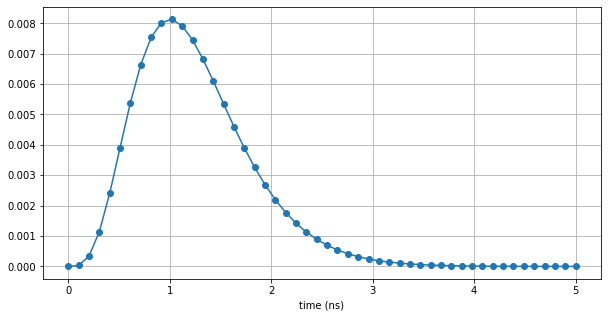

In [9]:
fig,ax=plt.subplots()
fig.set_figheight(5)
ax.plot(x0,np.multiply(bin,y0),marker="o")
ax.set_xlabel("time (ns)");
ax.grid()

In [10]:
x,bin = np.linspace(0,1500,1000+1,retstep=True)

In [11]:
y160 = [gamma4(time=x,startTime=0,peakingTime=160)*bin for x in x]

In [12]:
y300 = [gamma4(time=x,startTime=0,peakingTime=300)*bin for x in x]
assert math.isclose(x[np.argmax(y300)],300,rel_tol=1E-2), 'max should be reached at peakingTime'

In [13]:
x, len(x)

(array([   0. ,    1.5,    3. , ..., 1497. , 1498.5, 1500. ]), 1001)

In [14]:
slices=np.linspace(0,len(y300),16,True)[:-1].astype(int)
slices

array([  0,  66, 133, 200, 266, 333, 400, 467, 533, 600, 667, 734, 800,
       867, 934])

In [15]:
yd300=np.add.reduceat(y300,slices)/100
yd300

array([1.09896033e-04, 1.18751054e-03, 2.39468740e-03, 2.42912129e-03,
       1.80500378e-03, 1.07172219e-03, 5.54062842e-04, 2.57036297e-04,
       1.14423691e-04, 4.70668049e-05, 1.84945375e-05, 6.93942096e-06,
       2.60830841e-06, 9.32698451e-07, 3.26099202e-07])

In [16]:
sampleSize=100
xd300=np.add(0,np.arange(0,1500,sampleSize))
print(xd300)
yd300=[gamma4(time=x,startTime=0,peakingTime=300)*bin for x in xd300]


[   0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300
 1400]


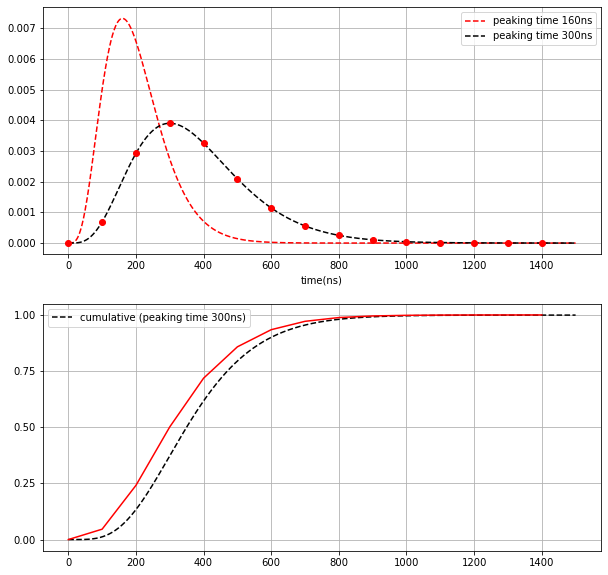

In [17]:
fig,(ax0,ax1)=plt.subplots(2,1)
ax0.plot(x,y160,color="red",linestyle="dashed",label="peaking time 160ns")
ax0.plot(x,y300,color="black",linestyle="dashed",label="peaking time 300ns")
ax0.plot(xd300,yd300,color="red",marker="o",linewidth=0)
ax0.set_xlabel("time(ns)")
ax0.legend()
ax0.grid()
ax1.plot(x,np.cumsum(y300),color="black",linestyle="dashed",label="cumulative (peaking time 300ns)")
ax1.plot(xd300,np.cumsum(np.multiply(yd300,sampleSize))/bin,color="red")
ax1.legend()
ax1.set_yticks(np.arange(0,1.2,0.25))
ax1.grid()

In [18]:
from collections.abc import Callable
import math

def K2fromK3(k3):
    sk3 = math.sqrt(k3)
    return (math.pi/2.0)*(1-0.5*sk3)

def K4fromK3(k3):
    k2 = K2fromK3(k3)
    sk3 = math.sqrt(k3)
    c1 = k2*sk3 / 4.0 / math.atan(sk3)
    return c1/k2/sk3

def integrate1D(x1,x2,*,pitch,k3) -> float:
    sk3 = math.sqrt(k3)
    k2 = K2fromK3(k3)
    k4 = K4fromK3(k3)
    inversePitch=1.0/pitch
    lambda1 = x1*inversePitch
    lambda2 = x2*inversePitch
    u1 = sk3*math.tanh(k2*lambda1)
    u2 = sk3*math.tanh(k2*lambda2)
    return k4*(math.atan(u1)-math.atan(u2))

def newChargeIntegrator(deid) -> Callable[[float,float,float,float], float]:
    station1 = deid<400
    if station1:
        k3x=0.49
        k3y=0.570025
        pitch=0.21
    else:
        k3x=0.50851161
        k3y=0.58400164
        pitch=0.25
    def integrator(x1,y1,x2,y2):
        return 4.0*integrate1D(x1,x2,pitch=pitch,k3=k3x)*integrate1D(y1,y2,pitch=pitch,k3=k3y)
    return integrator

i=newChargeIntegrator(100)
v=i(0,0,1,2)
expected=0.12498849 * 2.0
assert math.isclose(v,expected,rel_tol=1E-6)

In [ ]:
# see https://github.com/aphecetche/galo/blob/7829f9107777a86cf40faa3763fc97b0ec7a03de/mathieson/charge.go#L17

def newChargeSpreader(deid):
    def spreadCharge(*,charge,x,y):
        """Spread charge originating at (x,y) to a number of digits
        @return digits[]
        """
    
        # find p = pad at position (x,y)
        # find {nei} = neighbours of p
        # foreach p make a digit of charge q 
        #    where q = chargeOverBox(x,y,integrator,padboundingbox)
        #
        # for all this need the following functions from MCH mapping :
        # pb, pnb = findPadPairByPosition(x,y)
        # getNeighbours(pb) + getNeighbours(pnb)
        # computePadBoundingBox(paduid)
    return spreadCharge